In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.decomposition import PCA
import sklearn.cluster as cluster

 # Homework 4


## 1. Finding Similar Costumers

### 1.1 Set up the data

### 1.2 Fingerprint hashing

### 1.3 Locality Sensitive Hashing

## 2. Grouping customers together!

### 2.1 Getting your data + feature engineering

### 2.2 Choose your features (variables)!

### 2.3 Clustering!

In [75]:
df = pd.read_csv('bank_transactions.csv')
df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


## Mapping datas

#### We are going to map most of our features to numeric values so they can be suitable for clustering

In [87]:
df = df.dropna() #NaN values are not suitable for clustering

features = ['CustAccountBalance', 'TransactionTime', 'TransactionAmount (INR)'] #features that are already numeric

kmeans_df = df[features].copy()

#TransactionID
kmeans_df['NumericTransactionID'] = df['TransactionID'].str[1:].astype(int) #simple conversion from str to int

#CustomerID
kmeans_df['NumericCustomerID'] = df['CustomerID'].str[1:].astype(int) #simple conversion from str to int

#CustGender
df.loc[df['CustGender'] == 'F', 'NumericCustGender'] = float(0) #convert genders to 0 if female 
df.loc[df['CustGender'] == 'M', 'NumericCustGender'] = float(1) #convert genders to 1 if male
kmeans_df['NumericCustGender'] = df['NumericCustGender']

#CustomerDOB
l=[''.join(str(i).split('/', 1)) for i in list(df['CustomerDOB'])] #split values from 'NN/MM/KK' and join them to 'NNMM/KK'
l=[int(''.join(str(i).split('/', 1))) for i in l] #split values from 'NNMM/KK' and join them to 'NNMMKK', then convert them into integers
kmeans_df['NumericCustomerDOB'] = l #this column is now an integer NNMMKK of the string 'NN/MM/KK'

#TransactionDate
l=[''.join(str(i).split('/', 1)) for i in list(df['TransactionDate'])] #split values from 'NN/MM/KK' and join them to 'NNMM/KK'
l=[int(''.join(str(i).split('/', 1))) for i in l] #split values from 'NNMM/KK' and join them to 'NNMMKK', then convert them into integers
kmeans_df['NumericTransactionDate'] = l #this column is now an integer NNMMKK of the string 'NN/MM/KK'

kmeans_df = kmeans_df.dropna()

kmeans_df

,CustAccountBalance,TransactionTime,TransactionAmount (INR),NumericTransactionID,NumericCustomerID,NumericCustGender,NumericCustomerDOB,NumericTransactionDate
0,17819.05,143207,25.0,1,5841053,0.0,10194,2816
1,2270.69,141858,27999.0,2,2142763,1.0,4457,2816
2,17874.44,142712,459.0,3,4417068,0.0,261196,2816
3,866503.21,142714,2060.0,4,5342380,0.0,14973,2816
4,6714.43,181156,1762.5,5,9031234,0.0,24388,2816
...,...,...,...,...,...,...,...,...
1048562,7635.19,184824,799.0,1048563,8020229,1.0,8490,18916
1048563,27311.42,183734,460.0,1048564,6459278,1.0,20292,18916
1048564,221757.06,183313,770.0,1048565,6412354,1.0,18589,18916
1048565,10117.87,184706,1000.0,1048566,6420483,1.0,30878,18916


##### We are going to drop CustomerID and TransactionID because they are variables that indicies the dataframe, so they are not useful for clustering

##### We are also dropping CustGender because it would split the final clustering in 2 messy halves, and the dates features too because they are going to confuse the clustering as they do not correspond to a unique value. For example the date 11218 could be bot '11/2/18' and '1/12/18', which are two distinct datetimes.

In [98]:
kmeans_df = kmeans_df[features].copy()

#### This is the dataframe we are going to use for clustering

In [89]:
kmeans_df

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
0,17819.05,143207,25.0
1,2270.69,141858,27999.0
2,17874.44,142712,459.0
3,866503.21,142714,2060.0
4,6714.43,181156,1762.5
...,...,...,...
1048562,7635.19,184824,799.0
1048563,27311.42,183734,460.0
1048564,221757.06,183313,770.0
1048565,10117.87,184706,1000.0


## We will use a MapReduce paradigm to build the centroids

### Map

In [99]:

kmeans_df = ((kmeans_df - kmeans_df.min()) / (kmeans_df.max() - kmeans_df.min())) * 9 + 1  #this will make each value to go from 1 to 10


def get_centroids(dataframe, k): #k is the number of clusters we want

    centroids = []
    
    for i in range(k):
        
        cent = dataframe.apply(lambda x: float(x.sample())) #iterates every column and takes random values, then cast them into floats
        
        centroids.append(cent)
    return pd.concat(centroids,axis=1)



centroids = get_centroids(kmeans_df, 4)

In [100]:
centroids

,0,1,2,3
CustAccountBalance,1.025605,1.012180,1.119204,1.000038
TransactionTime,7.557220,4.948635,1.504049,6.023941
TransactionAmount (INR),1.001817,1.005971,1.059364,1.008959


In [91]:
distances = centroids.apply(lambda x: np.sqrt((( kmeans_df - x) ** 2).sum(axis=1))) #calculate the distances from dataframe rows and centroids

clusters = distances.idxmin(axis=1) #assign each row to a cluster

In [92]:
clusters.value_counts() #distribution of data entries within the clusters

2    470622
3    289651
1    152921
0    128419
dtype: int64

### Reduce

In [93]:
new_centroids = kmeans_df.groupby(clusters).apply(lambda x: np.exp(np.log(x).mean())) #updated centroids based on geometric mean

#### Plotting

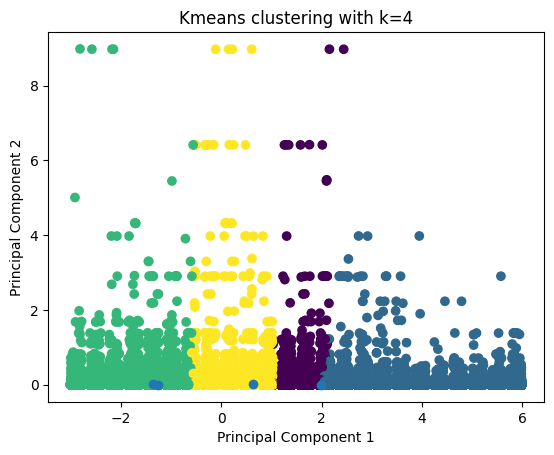

In [94]:
from sklearn.decomposition import PCA

principal_components = sklearn.decomposition.PCA(n_components = 2) 

fit_components = principal_components.fit_transform(kmeans_df)

fit_centroids = principal_components.fit_transform(centroids.T)

kmeans_df['Cluster'] = clusters

plt.title('Kmeans clustering with k=4')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.scatter(x=fit_components[:,0], y=fit_components[:,1], c=clusters)
plt.scatter(x=fit_centroids[:,0], y=fit_centroids[:,1])
plt.show()

#### Scikit's Kmeans++

In [31]:
kmeans_df = ((kmeans_df - kmeans_df.min()) / (kmeans_df.max() - kmeans_df.min())) * 9 + 1 

kmeans = cluster.KMeans(n_clusters = 4, init ='k-means++')

kmeans = kmeans.fit(kmeans_df)

kmeans_df['cluster'] = kmeans.labels_


In [32]:
kmeans_df['cluster'].value_counts()

0    435254
2    329233
1    229004
3     52707
Name: cluster, dtype: int64

<AxesSubplot: xlabel='TransactionTime', ylabel='CustAccountBalance'>

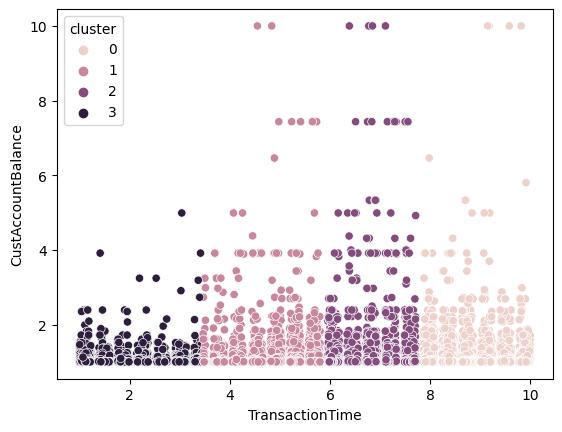

In [33]:
sns.scatterplot(x = 'TransactionTime', y='CustAccountBalance', hue = 'cluster', data = kmeans_df)

## Choosing optimal number of clusters

In [38]:
n_clusters = []
Krange = range(1,11)

for k in range(1,11):
    
    km = KMeans(n_clusters = k)
    km = km.fit(kmeans_df)
    n_clusters.append(km.inertia_)

#### Elbow Method

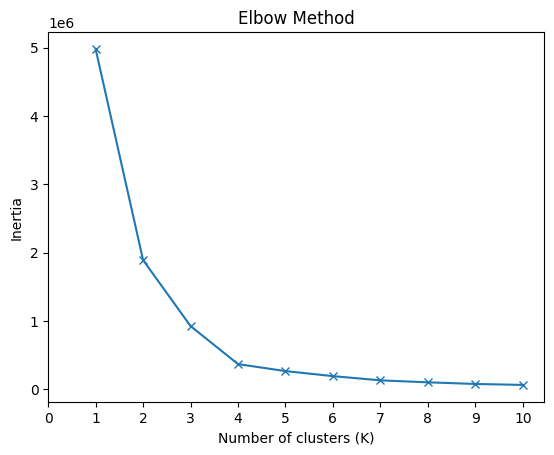

In [39]:
plt.plot(Krange, n_clusters, marker = 'x')
plt.xlabel('Number of clusters (K)')
plt.xticks(np.arange(11))
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

This plot shows the loss of accuracy based on the number of clusters. The optimal number of clusters occurs whe the curve starts to flatten, In this case we could choose a number of clusters of 4.

#### Silhouette score

We will use a semple size of 5000

In [37]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)

km.fit(kmeans_df)

score = silhouette_score(kmeans_df, km.labels_, metric='euclidean', sample_size = 50000)

print('Silhouette Score for K=3: %.3f' % score)

Silhouette Score for K=3: 0.620


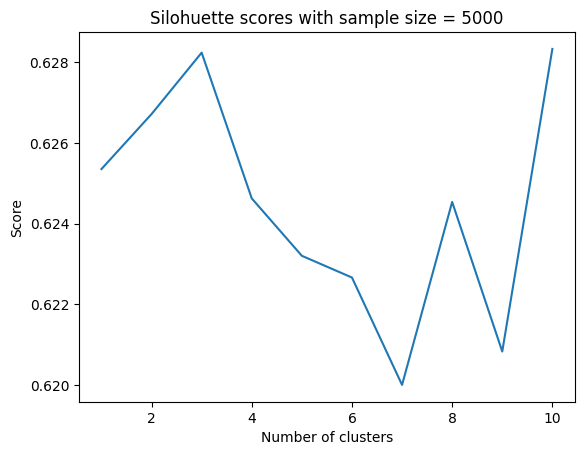

In [36]:
x=[]
scores=[]

for i in range(1,11):
    km = KMeans(n_clusters=3, random_state=42)

    km.fit(kmeans_df)

    score = silhouette_score(kmeans_df, km.labels_, metric='euclidean', sample_size = 50000)
    
    x.append(i)
    scores.append(score)

plt.title('Silohuette scores with sample size = 50000')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.plot(x, scores)
plt.show()

The Silhouette score is a number from the interval [-1,1]. The effecency of the clustering method is proportional to the Silhouette score value, for example if we get a number lower than 0 we know that we choose a bad performing number of clusters. In this case we get that the optimal number of clusters is 3.